In [1]:
'''
This code block converts a networkX LFR benchmark graph to format compatible with pyg/pytorch. 
LFR in networkX creates  a node attribute that 
'''
## Basic Imports
import numpy as np
from utils import line_gaussians
import gc
from tqdm import tqdm

## NetworkX imports
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph as LFR

## PyG imports
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils.convert import to_networkx ,from_networkx
from torch_geometric.data import Data





In [2]:
class synthData():
    def __init__(self, type = "LFR", n=1000, mu = 0.1, feat_len = 32, noise = 2, loc = 0):
        self.type = type
        self.feat_len = feat_len
        
        if self.type == "LFR":
            self.graph = self.gen_LFR(n, mu, noise,loc)
        else:
            pass


    def gen_LFR(self, n, mu,noise, loc):
        LFR_graph = LFR(n= n, tau1= 2, 
                        tau2 = 1.1,mu = mu, 
                        average_degree = 25 , 
                        max_degree = int(0.1*n),
                        min_community = int(0.1*n),
                        max_community = int(0.1*n))
        LFR_graph.remove_edges_from(nx.selfloop_edges(LFR_graph))
        labels_dict = nx.get_node_attributes(LFR_graph, "community")
        y = self.y = self.get_ground_truth(labels_dict) 
        num_communities = len(set(y))
        clean, dirty, labels = line_gaussians(n_points = n, n_clusters=num_communities ,loc_scale=loc,
                                              noise_scale = noise, feat_len = self.feat_len)
        self.clean = self.get_node_feats(y,labels, clean)
        self.dirty = self.get_node_feats(y,labels, dirty)
        LFR_pyg = self.nx_to_pyg(LFR_graph, y)
        return LFR_pyg
        
    def gen_LFR_bad(self):
        temp_graph = self.graph.clone()
        temp_graph.x = self.noisy_feats
        return temp_graph
        

    def plot_graph(self):
        vis = to_networkx(self.graph)
        vis.remove_edges_from(nx.selfloop_edges(vis))
        
        
        node_labels = self.y.numpy(force=True)
        
        import matplotlib.pyplot as plt
        plt.figure(1,figsize=(15,13)) 
        nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=20,linewidths=6)
        plt.show()

    def get_ground_truth(self, labels):
        collect_values= []
        for keys, values in labels.items():
            if values not in collect_values:
                collect_values.append(values)

        dict_labels = {}
        for i in range(len(collect_values)):
            y_labels = {labels:i for labels in collect_values[i]}
            dict_labels.update(y_labels)
        y_labels = dict(sorted(dict_labels.items()))
        y = [values for keys,values in y_labels.items()]
        return y

    def get_node_feats(self, response, label_set, feats):
        node_feats = np.zeros((feats.shape[0], feats.shape[1]))
        for k in range(len(label_set)):
            id1 = [i for i, j in enumerate(response) if j == k]
            id2 = [i for i, j in enumerate(label_set) if j == k]
            node_feats[id1, :] = feats[id2,:]
        return node_feats

    def nx_to_pyg(self, graph, response):
        feats = self.clean
        num_nodes = len(graph.nodes)
        x = torch.tensor(feats, dtype = torch.float )
        edge_index = from_networkx(graph).edge_index
        edge_index = torch.tensor(edge_index, dtype = torch.long)
        y = torch.tensor(response, dtype = torch.long)
        omega = np.zeros(num_nodes, dtype = bool)
        idx = np.random.choice(range(num_nodes),
                                            size = int(0.2*num_nodes),
                                            replace =False)
        omega[idx] =True
        train_mask = omega
        test_mask = ~train_mask
        temp_feats = self.clean
        temp_feats[test_mask] = self.dirty[test_mask]
        x_pert= torch.tensor(temp_feats, dtype = torch.float)
        self.noisy_feats = x_pert
        G = Data(x = x, edge_index = edge_index, y=y,
                 train_mask = torch.tensor(train_mask),
                 test_mask = torch.tensor(test_mask))
        return G
        
        
        
class GCN(torch.nn.Module):
    def __init__(self, data):
        super().__init__()
        self.x = data.x 
        self.num_feats = data.x.shape[1]
        self.num_labels= len(set(data.y))
        self.conv1 = GCNConv(self.num_feats, 16)
        self.conv2 = GCNConv(16, self.num_labels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1) 

class GAT(torch.nn.Module):
    def __init__(self,data):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        self.num_classes = len(set(data.y))
        self.num_feats = data.x.shape[0]
        self.conv1 = GATConv(self.num_feats, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, self.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
        
        

In [3]:
data = synthData(n = 1000,mu = 0.1,feat_len= 50,noise = 2)
good_data = data.graph
bad_data = data.gen_LFR_bad()



C:\Users\jaide\AppData\Local\Temp\ipykernel_20952\3155481393.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype = torch.long)


In [6]:
noise = 2
step = 2
range(0, noise, step)

range(0, 2, 2)

In [3]:
#Experiment Design to understand affect of degree of the scale parameter in attack. 
#mu = 0.1 
#n = 1000
#feat_len = 500

'''
VARY SCALE
'''

noise_vect = range(0,100,2)
n_runs = 5
mean_acc_good= []
mean_acc_bad = []
for noise in tqdm(noise_vect):
    data = synthData(n = 1000,mu = 0.1,feat_len= 500,noise = noise)
    good_data = data.graph
    bad_data = data.gen_LFR_bad()
    acc_good= []
    acc_bad = []
    for i in range(n_runs):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = GCN(good_data).to(device)
        good_data = good_data.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        
        model.train()
        for epoch in range(200):
            optimizer.zero_grad()
            out = model(good_data)
            loss = F.nll_loss(out[good_data.train_mask], good_data.y[good_data.train_mask])
            loss.backward()
            optimizer.step()

        model.eval()
        pred = model(good_data).argmax(dim=1)
        correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
        acc = int(correct) / good_data.test_mask.sum()
        acc = acc.numpy(force=True)
        acc_good.append(acc)
        
        bad_data = bad_data.to(device)
        model.eval()
        pred = model(bad_data).argmax(dim=1)
        correct = (pred[bad_data.test_mask]== bad_data.y[bad_data.test_mask]).sum()
        acc = int(correct) / bad_data.test_mask.sum()
        acc = acc.numpy(force=True)
        acc_bad.append(acc)
    mean_acc_good.append(np.mean(acc_good))
    mean_acc_bad.append(np.mean(acc_bad))

        
                
        
        
    



  0%|                                                                                           | 0/50 [00:00<?, ?it/s]C:\Users\jaide\AppData\Local\Temp\ipykernel_35824\3155481393.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype = torch.long)
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:49<00:00,  7.00s/it]


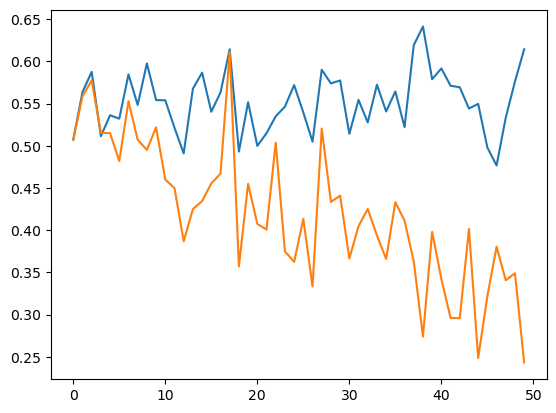

In [5]:
from matplotlib import pyplot as plt
plt.plot(mean_acc_good)
plt.plot(mean_acc_bad)


In [6]:
#Experiment Design to understand affect of degree of the scale parameter in attack. 
#mu = 0.1 
#n = 1000
#feat_len = 500

'''
VARY MEAN AND SCALE
'''

noise_vect = np.arange(0,10,2)
loc_vect = np.arange(0,3,0.6)

n_runs = 5
mean_acc_good= []
mean_acc_bad = []
for noise in tqdm(noise_vect):
    acc_per_loc_bad = []
    for loc in tqdm(loc_vect):
        data = synthData(n = 1000,mu = 0.1,feat_len= 500,noise = noise, loc=loc)
        good_data = data.graph
        bad_data = data.gen_LFR_bad()
        acc_good= []
        acc_bad = []
        for i in range(n_runs):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = GCN(good_data).to(device)
            good_data = good_data.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            
            model.train()
            for epoch in range(200):
                optimizer.zero_grad()
                out = model(good_data)
                loss = F.nll_loss(out[good_data.train_mask], good_data.y[good_data.train_mask])
                loss.backward()
                optimizer.step()
    
            model.eval()
            pred = model(good_data).argmax(dim=1)
            correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
            acc = int(correct) / good_data.test_mask.sum()
            acc = acc.numpy(force=True)
            acc_good.append(acc)
            
            bad_data = bad_data.to(device)
            model.eval()
            pred = model(bad_data).argmax(dim=1)
            correct = (pred[bad_data.test_mask]== bad_data.y[bad_data.test_mask]).sum()
            acc = int(correct) / bad_data.test_mask.sum()
            acc = acc.numpy(force=True)
            acc_bad.append(acc)
        acc_per_loc_bad.append(np.mean(acc_bad))
    mean_acc_good.append(np.mean(acc_good))
    mean_acc_bad.append(acc_per_loc_bad)

        
                
        
        
    




  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\jaide\AppData\Local\Temp\ipykernel_35824\3155481393.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype = torch.long)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:00<00:00, 36.06s/it]


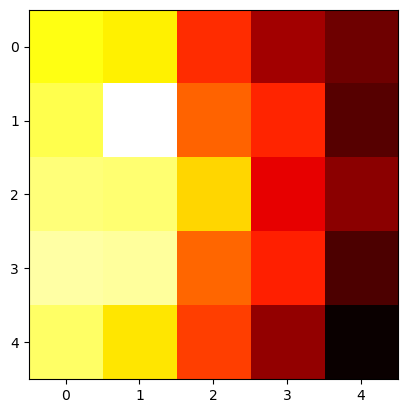

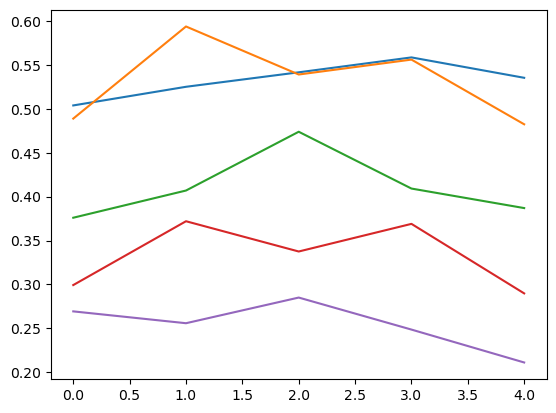

In [9]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib as mpl
plt.imshow(mean_acc_bad, cmap='hot', interpolation='nearest')
plt.show()
plt.plot(mean_acc_bad)

In [18]:
loc_vect

array([0. , 0.6, 1.2, 1.8, 2.4])

In [11]:
noise_vect = np.arange(0,20,4)
feat_len = [32,64,128,256,512]

'''
VARY FEATURE SIZE AND SCALE
'''


n_runs = 5
mean_acc_good= []
mean_acc_bad = []
for noise in tqdm(noise_vect):
    acc_per_loc_bad = []
    for feat in tqdm(feat_len):
        data = synthData(n = 1000,mu = 0.1,feat_len= feat,noise = noise)
        good_data = data.graph
        bad_data = data.gen_LFR_bad()
        acc_good= []
        acc_bad = []
        for i in range(n_runs):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = GCN(good_data).to(device)
            good_data = good_data.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            
            model.train()
            for epoch in range(200):
                optimizer.zero_grad()
                out = model(good_data)
                loss = F.nll_loss(out[good_data.train_mask], good_data.y[good_data.train_mask])
                loss.backward()
                optimizer.step()
    
            model.eval()
            pred = model(good_data).argmax(dim=1)
            correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
            acc = int(correct) / good_data.test_mask.sum()
            acc = acc.numpy(force=True)
            acc_good.append(acc)
            
            bad_data = bad_data.to(device)
            model.eval()
            pred = model(bad_data).argmax(dim=1)
            correct = (pred[bad_data.test_mask]== bad_data.y[bad_data.test_mask]).sum()
            acc = int(correct) / bad_data.test_mask.sum()
            acc = acc.numpy(force=True)
            acc_bad.append(acc)
        acc_per_loc_bad.append(np.mean(acc_bad))
    mean_acc_good.append(np.mean(acc_good))
    mean_acc_bad.append(acc_per_loc_bad)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\jaide\AppData\Local\Temp\ipykernel_35824\3155481393.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype = torch.long)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.78s/it]


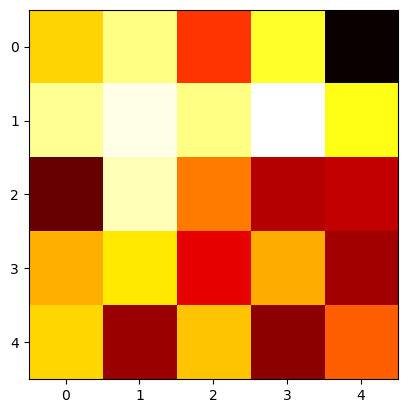

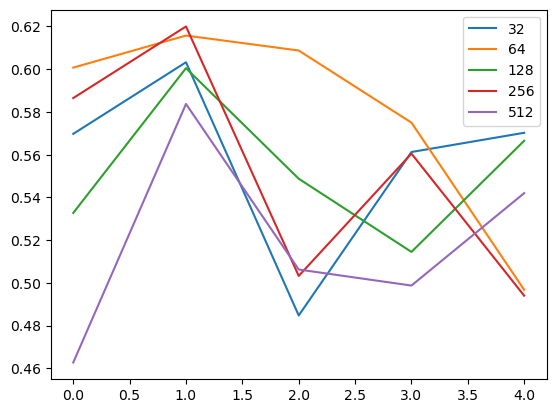

In [15]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib as mpl
plt.imshow(mean_acc_bad, cmap='hot', interpolation='nearest')
plt.show()
plt.plot(mean_acc_bad,label=feat_len)
plt.legend()

In [ ]:
pip install seaborn --upgrade

<Axes: >

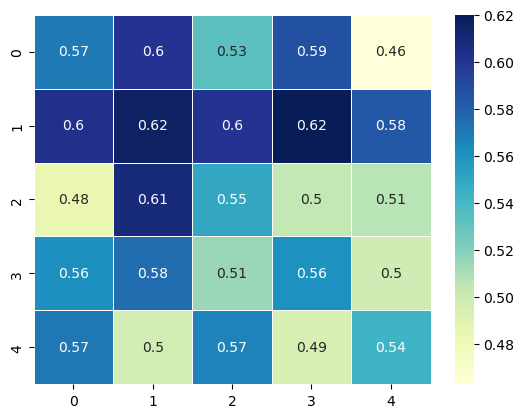

In [17]:

import seaborn as sns
sns.heatmap(mean_acc_bad, annot=True, cmap='YlGnBu', linewidths=.5)

In [40]:
class GAT(torch.nn.Module):
    def __init__(self,data):
        super(GAT, self).__init__()
        self.hid = 16
        self.in_head = 16
        self.out_head = 1
        
        self.num_classes = len(set(data.y))
        self.num_feats = 50
        self.conv1 = GATConv(self.num_feats, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, self.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [41]:
input_data = good_data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_gat1 = GAT(input_data).to(device)
input_data = input_data.to(device)
optimizer = torch.optim.Adam(model_gat1.parameters(), lr=0.01, weight_decay=5e-4)

In [42]:
num_runs = 100
tot_acc = 0
tot_norm= 0
for run in range(num_runs):
    model_gat1.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model_gat1(input_data)
        loss = F.nll_loss(out[input_data.train_mask], input_data.y[input_data.train_mask])
        loss.backward()
        optimizer.step()
    model_gat1.eval()
    pred = model_gat1(input_data).argmax(dim=1)
    correct = (pred[input_data.test_mask] == input_data.y[input_data.test_mask]).sum()
    acc = int(correct) / int(input_data.test_mask.sum())
    tot_acc += acc
    tot_norm += norm
    print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1562
Accuracy: 0.1212
Accuracy: 0.2338
Accuracy: 0.1600
Accuracy: 0.1737
Accuracy: 0.2225
Accuracy: 0.2087
Accuracy: 0.1713
Accuracy: 0.1888
Accuracy: 0.1762
Accuracy: 0.1613
Accuracy: 0.1263
Accuracy: 0.1450
Accuracy: 0.1688


KeyboardInterrupt: 

tensor(800, device='cuda:0')

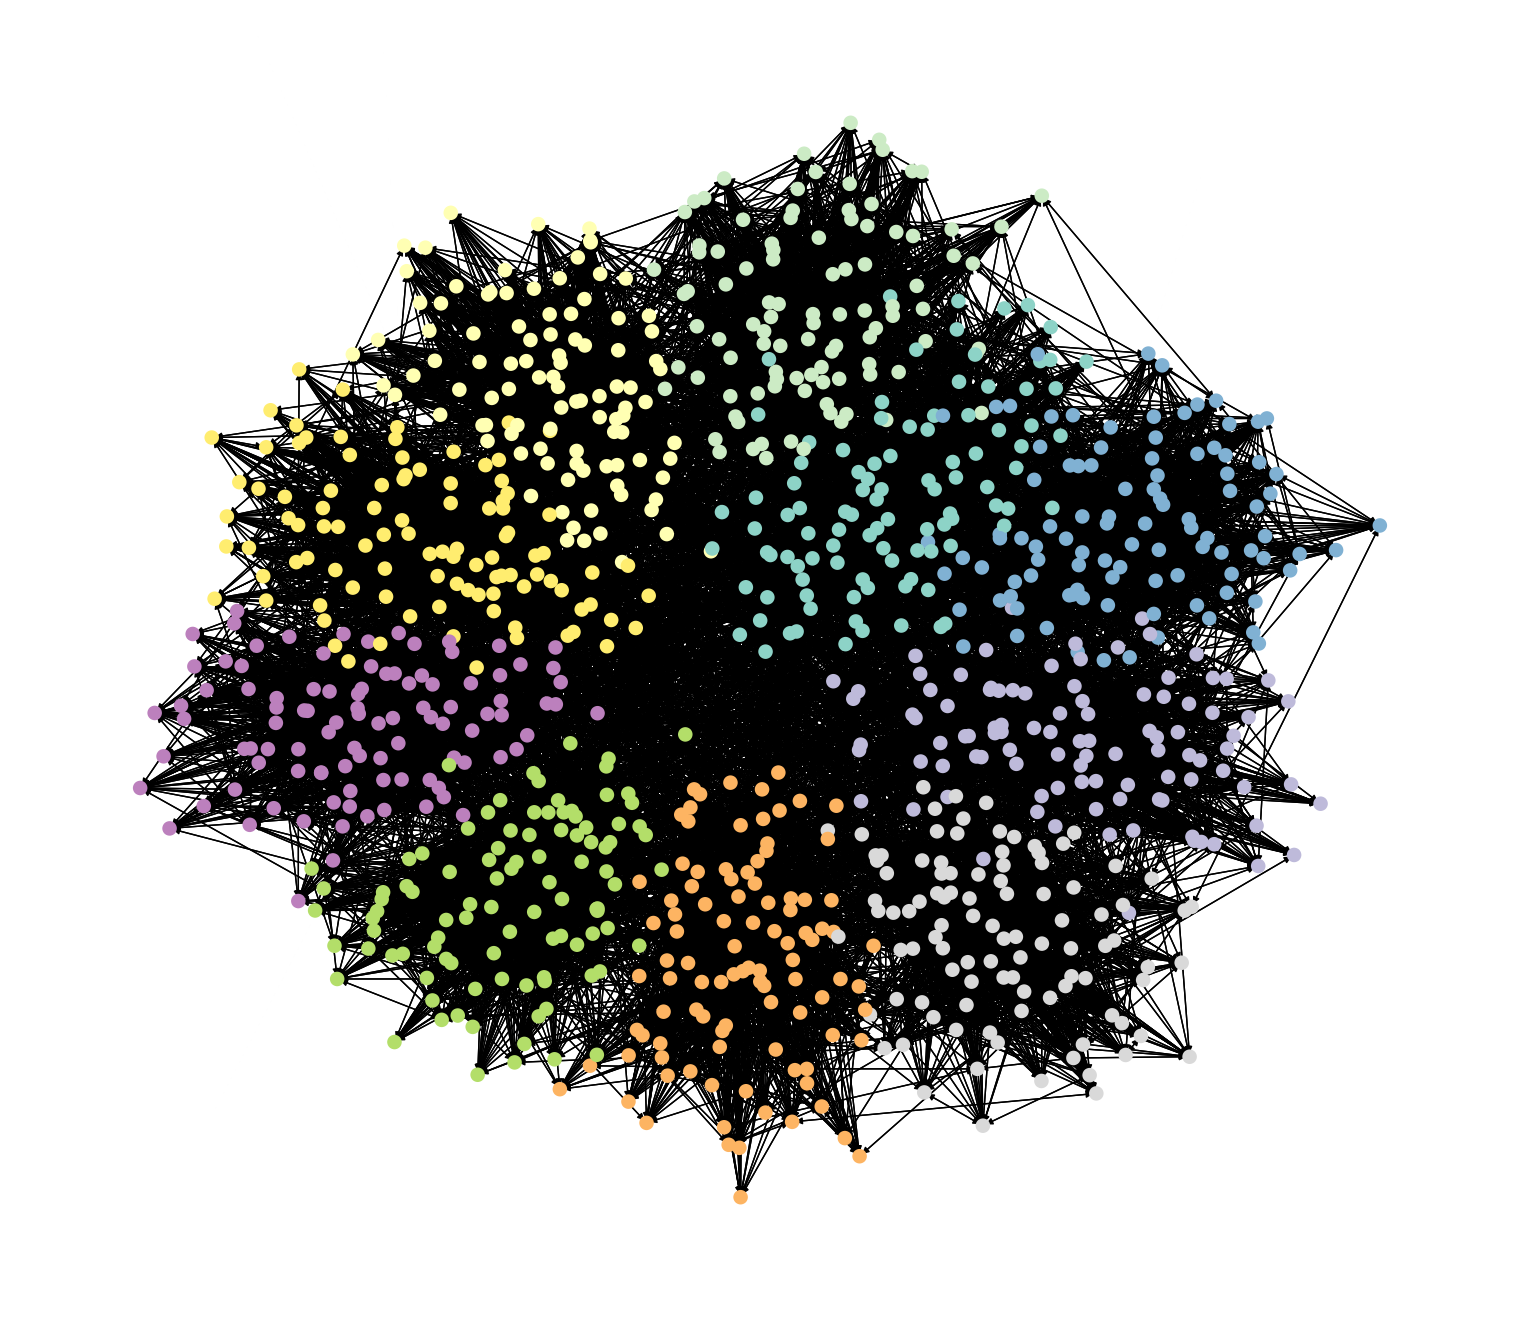

In [284]:
vis = to_networkx(data.graph)
vis.remove_edges_from(nx.selfloop_edges(vis))


node_labels = data.graph.y.numpy(force= True)

import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=20,linewidths=6)
plt.show()

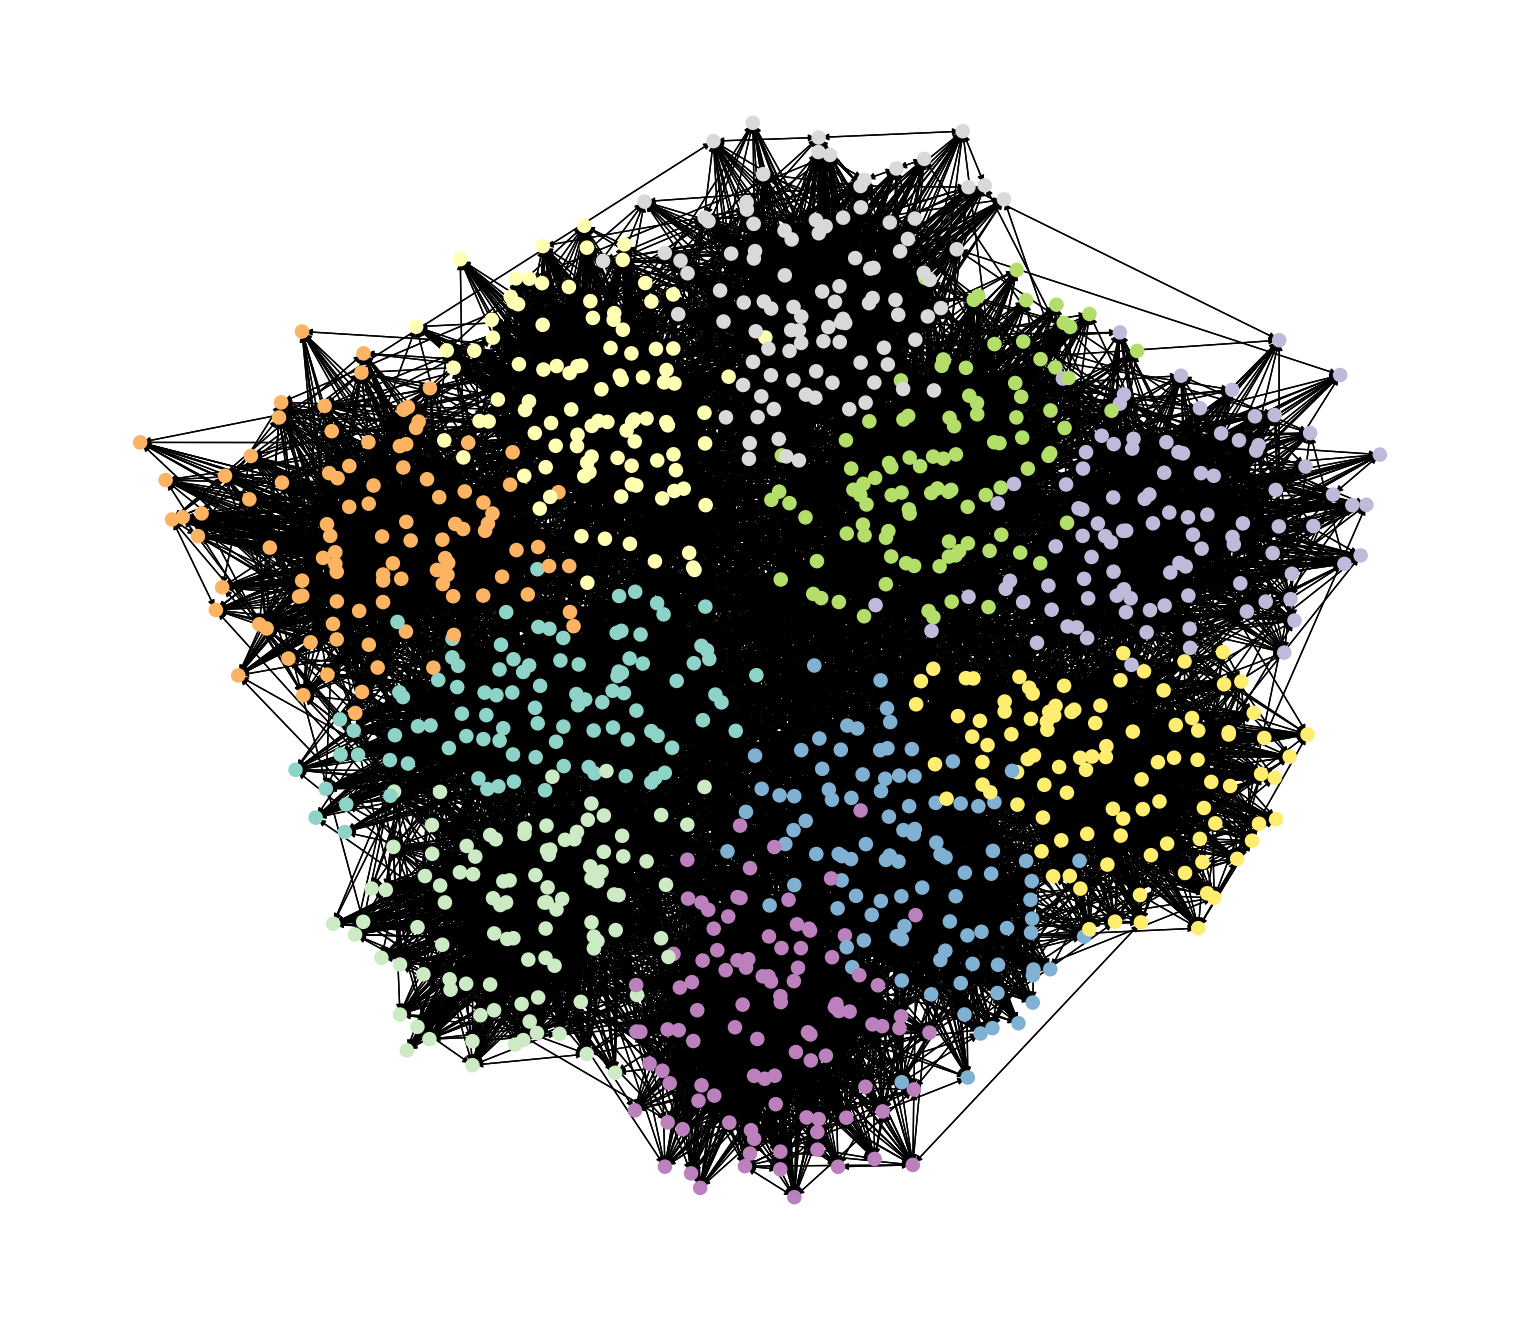

In [285]:
vis = to_networkx(bad_data)
vis.remove_edges_from(nx.selfloop_edges(vis))


node_labels = bad_data.y.numpy(force= True)

import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=20,linewidths=6)
plt.show()

In [54]:
clea, dirty, label = line_gaussians(1000, n_clusters = 15)
len(label)
1000 / 

15.151515151515152

In [86]:
omega = np.zeros(1000, dtype = bool)
train_idx = np.random.choice(range(1000), size = 800, replace= False)
omega[train_idx] = True
test = ~omega
test.sum()

200

In [9]:
#Data Set Creation and Pre-Processing. 

# tau1 and tau2 have to be set at 0.1N 

# NUmber of synthetic features reduce to 32
#-----------------------------------------------------------------------------------------------------------------------#
# Parameters for LFR benchmark
num_nodes = 1000
tau1 = 5
tau2 = 2
mu = 0.1 
average_degree = 20
min_community = 100
max_community = 100
communities = 10
num_features = 32



# I create an LFR bench mark dataset
graph = LFR(n= num_nodes, tau1= tau1, 
            tau2 = tau2,mu = mu, 
            average_degree = average_degree , 
            min_community = min_community,
            max_community = max_community)
#------------------------------------------------------------------------------------------------------------------------#

In [10]:
# I extract the community labels.
labelsdict= nx.get_node_attributes(graph, "community")

collect_values= []
for keys, values in labelsdict.items():
    if values not in collect_values:
        collect_values.append(values)

dict_labels = {}
for i in range(len(collect_values)):
    y_labels = {labels:i for labels in collect_values[i]}
    dict_labels.update(y_labels)
y_labels = dict(sorted(dict_labels.items()))
y = [values for keys,values in y_labels.items()]

#-----------------------------------------------------------------------------------------------------------------------------

#Parameters for synthetic node attributes
num_communities = len(collect_values)
node_feats_clean, node_feats_dirty,labels = line_gaussians(num_nodes, num_communities)

#Rearrange node features as per clusters. 
node_feats = np.zeros((num_nodes, num_features))
for k in range(len(labels)):
    id1 = [i for i, j in enumerate(y) if j == k]
    id2 = [i for i, j in enumerate(labels) if j == k]
    node_feats[id1, :] = node_feats_clean[id2,:]


In [13]:
node_feats_clean.shape[1]


32

In [32]:
np.random.normal(4,size=(10,32))

array([[2.37329435, 5.56894192, 3.32370833, 2.47865353, 5.31820993,
        3.65007452, 5.98746337, 2.95961299, 4.75364695, 1.22598048,
        3.15528302, 4.23999536, 2.86049821, 4.82110584, 5.04321102,
        3.68534907, 4.53118538, 5.96759153, 4.10382528, 3.98897738,
        4.55708118, 2.81681689, 2.73058128, 4.13226881, 5.17918781,
        3.01594674, 2.88362925, 4.12049489, 3.34545692, 2.94627309,
        4.99523282, 3.00184719],
       [2.62255442, 3.38598381, 4.41369025, 5.03917996, 5.17896983,
        3.9944294 , 3.17627171, 4.92166711, 3.00663582, 2.56921592,
        4.01090796, 5.92867491, 3.92062721, 5.60219683, 4.59719844,
        3.61994123, 3.65683915, 3.47890129, 3.59323161, 4.63970133,
        3.98793556, 5.11445619, 4.3200668 , 2.13383859, 5.54377493,
        2.49891831, 3.94810183, 4.70676223, 4.56873544, 3.26306996,
        2.87868207, 3.37146588],
       [3.45267714, 4.15694374, 3.4317373 , 2.14459075, 5.99100376,
        3.22997669, 4.18314105, 2.57726571, 2.5244

In [4]:
#Make PyG graph of LFR

test= from_networkx(graph)
test.x = torch.tensor(node_feats)
test.y = torch.tensor(y)
lfr_test = Data(x=torch.tensor(test.x,dtype = torch.float), 
            edge_index = torch.tensor(test.edge_index, dtype = torch.long),
            y = torch.tensor(test.y, dtype = torch.long))



#Visualize Graph
# vis = to_networkx(lfr_test)
# vis.remove_edges_from(nx.selfloop_edges(vis))


# node_labels = lfr_test.y.numpy()

# import matplotlib.pyplot as plt
# plt.figure(1,figsize=(15,13)) 
# nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=20,linewidths=6)
# plt.show()

C:\Users\jaide\AppData\Local\Temp\ipykernel_34420\787407364.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lfr_test = Data(x=torch.tensor(test.x,dtype = torch.float),
C:\Users\jaide\AppData\Local\Temp\ipykernel_34420\787407364.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(test.edge_index, dtype = torch.long),
C:\Users\jaide\AppData\Local\Temp\ipykernel_34420\787407364.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(test.y, dtype = torch.long))


In [ ]:
len(labels)

In [16]:
class GCN(torch.nn.Module):
    def __init__(self, data):
        super().__init__()
        self.x = data.x 
        self.num_feats = data.x.shape[1]
        self.num_labels= len(set(data.y))
        self.conv1 = GCNConv(self.num_feats, 16)
        self.conv2 = GCNConv(16, self.num_labels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(good_data).to(device)
good_data = good_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(good_data)
    loss = F.nll_loss(out[good_data.train_mask], good_data.y[good_data.train_mask])
    loss.backward()
    optimizer.step()

In [14]:
model.eval()
pred = model(good_data).argmax(dim=1)
correct = (pred[good_data.test_mask]== good_data.y[good_data.test_mask]).sum()
acc = int(correct) / good_data.test_mask.sum()
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.5875


In [15]:
bad_data = bad_data.to(device)
model.eval()
pred = model(bad_data).argmax(dim=1)
correct = (pred[bad_data.test_mask]== bad_data.y[bad_data.test_mask]).sum()
acc = int(correct) / bad_data.test_mask.sum()
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.2825


In [11]:
test = np.random.normal(scale= 10, size = (800,500))
np.mean(test)

-0.0174057093912302

In [67]:
#----------------------------------------------------------------------------------------------------------------
"""
DMonPooling PyG

"""
#----------------------------------------------------------------------------------------------------------------

from torch_geometric.loader import DataLoader
from torch_geometric.nn import DenseGraphConv, DMoNPooling, GCNConv
from torch_geometric.utils import to_dense_adj, to_dense_batch

import torch
import torch.nn.functional as F
from torch.nn import Linear

train_loader = DataLoader(lfr_test, batch_size=50)

class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        num_nodes = 500
        self.pool1 = DMoNPooling([hidden_channels, hidden_channels], num_nodes)

        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        num_nodes = 250
        self.pool2 = DMoNPooling([hidden_channels, hidden_channels], num_nodes)

        self.conv3 = DenseGraphConv(hidden_channels, hidden_channels)

        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index).relu()

        # x, mask = to_dense_batch(x, batch)
        # adj = to_dense_adj(edge_index, batch)

        _, x, adj, sp1, o1, c1 = self.pool1(x, adj, mask)

        x = self.conv2(x, adj).relu()

        _, x, adj, sp2, o2, c2 = self.pool2(x, adj)

        x = self.conv3(x, adj)

        x = x.mean(dim=1)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), sp1 + sp2 + o1 + o2 + c1 + c2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features, len(labels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data, data.)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred== data.y).sum()
acc = int(correct) / int(data.y.sum())
print(f'Accuracy: {acc:.4f}')


# @torch.no_grad()
# def test(loader):
#     model.eval()
#     correct = 0
#     loss_all = 0

#     for data in loader:
#         data = data.to(device)
#         pred, tot_loss = model(data.x, data.edge_index, data.batch)
#         loss = F.nll_loss(pred, data.y.view(-1)) + tot_loss
#         loss_all += data.y.size(0) * float(loss)
#         correct += int(pred.max(dim=1)[1].eq(data.y.view(-1)).sum())

#     return loss_all / len(loader.dataset), correct / len(loader.dataset)


# for epoch in range(1, 101):
#     train_loss = train(data)
#     # _, train_acc = test(train_loader)
#     # val_loss, val_acc = test(val_loader)
#     # test_loss, test_acc = test(test_loader)
#     print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.3f}')
    # , '
          # f'Train Acc: {train_acc:.3f}, Val Loss: {val_loss:.3f}, '
          # f'Val Acc: {val_acc:.3f}, Test Loss: {test_loss:.3f}, '
          # f'Test Acc: {test_acc:.3f}')

TypeError: Net.forward() missing 2 required positional arguments: 'edge_index' and 'batch'

In [70]:
import os.path as osp
from math import ceil

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import DenseGraphConv, DMoNPooling, GCNConv
from torch_geometric.utils import to_dense_adj, to_dense_batch

# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'PROTEINS')
dataset = TUDataset(root='/tmp/Proteins' , name='PROTEINS').shuffle()
avg_num_nodes = int(dataset.data.x.size(0) / len(dataset))
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
test_loader = DataLoader(test_dataset, batch_size=20)
val_loader = DataLoader(val_dataset, batch_size=20)
train_loader = DataLoader(train_dataset, batch_size=20)


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        num_nodes = ceil(0.5 * avg_num_nodes)
        self.pool1 = DMoNPooling([hidden_channels, hidden_channels], num_nodes)

        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        num_nodes = ceil(0.5 * num_nodes)
        self.pool2 = DMoNPooling([hidden_channels, hidden_channels], num_nodes)

        self.conv3 = DenseGraphConv(hidden_channels, hidden_channels)

        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()

        x, mask = to_dense_batch(x, batch)
        adj = to_dense_adj(edge_index, batch)

        _, x, adj, sp1, o1, c1 = self.pool1(x, adj, mask)

        x = self.conv2(x, adj).relu()

        _, x, adj, sp2, o2, c2 = self.pool2(x, adj)

        x = self.conv3(x, adj)

        x = x.mean(dim=1)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), sp1 + sp2 + o1 + o2 + c1 + c2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train(train_loader):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, tot_loss = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y.view(-1)) + tot_loss
        loss.backward()
        loss_all += data.y.size(0) * float(loss)
        optimizer.step()
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    loss_all = 0

    for data in loader:
        data = data.to(device)
        pred, tot_loss = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1)) + tot_loss
        loss_all += data.y.size(0) * float(loss)
        correct += int(pred.max(dim=1)[1].eq(data.y.view(-1)).sum())

    return loss_all / len(loader.dataset), correct / len(loader.dataset)


for epoch in range(1, 101):
    train_loss = train(train_loader)
    _, train_acc = test(train_loader)
    val_loss, val_acc = test(val_loader)
    test_loss, test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.3f}, '
          f'Train Acc: {train_acc:.3f}, Val Loss: {val_loss:.3f}, '
          f'Val Acc: {val_acc:.3f}, Test Loss: {test_loss:.3f}, '
          f'Test Acc: {test_acc:.3f}')

Processing...
Done!
C:\Users\jaide\anaconda3\envs\GNNs\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 001, Train Loss: 4.008, Train Acc: 0.721, Val Loss: 4.053, Val Acc: 0.768, Test Loss: 4.001, Test Acc: 0.804
Epoch: 002, Train Loss: 3.960, Train Acc: 0.719, Val Loss: 4.029, Val Acc: 0.777, Test Loss: 3.982, Test Acc: 0.768
Epoch: 003, Train Loss: 3.945, Train Acc: 0.730, Val Loss: 4.010, Val Acc: 0.786, Test Loss: 3.963, Test Acc: 0.786
Epoch: 004, Train Loss: 3.934, Train Acc: 0.728, Val Loss: 4.011, Val Acc: 0.804, Test Loss: 3.956, Test Acc: 0.777
Epoch: 005, Train Loss: 3.921, Train Acc: 0.733, Val Loss: 4.003, Val Acc: 0.804, Test Loss: 3.944, Test Acc: 0.777
Epoch: 006, Train Loss: 3.911, Train Acc: 0.733, Val Loss: 4.003, Val Acc: 0.795, Test Loss: 3.938, Test Acc: 0.795
Epoch: 007, Train Loss: 3.903, Train Acc: 0.735, Val Loss: 4.001, Val Acc: 0.795, Test Loss: 3.934, Test Acc: 0.795
Epoch: 008, Train Loss: 3.898, Train Acc: 0.732, Val Loss: 4.001, Val Acc: 0.786, Test Loss: 3.933, Test Acc: 0.795
Epoch: 009, Train Loss: 3.894, Train Acc: 0.733, Val Loss: 4.001, Val Ac

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

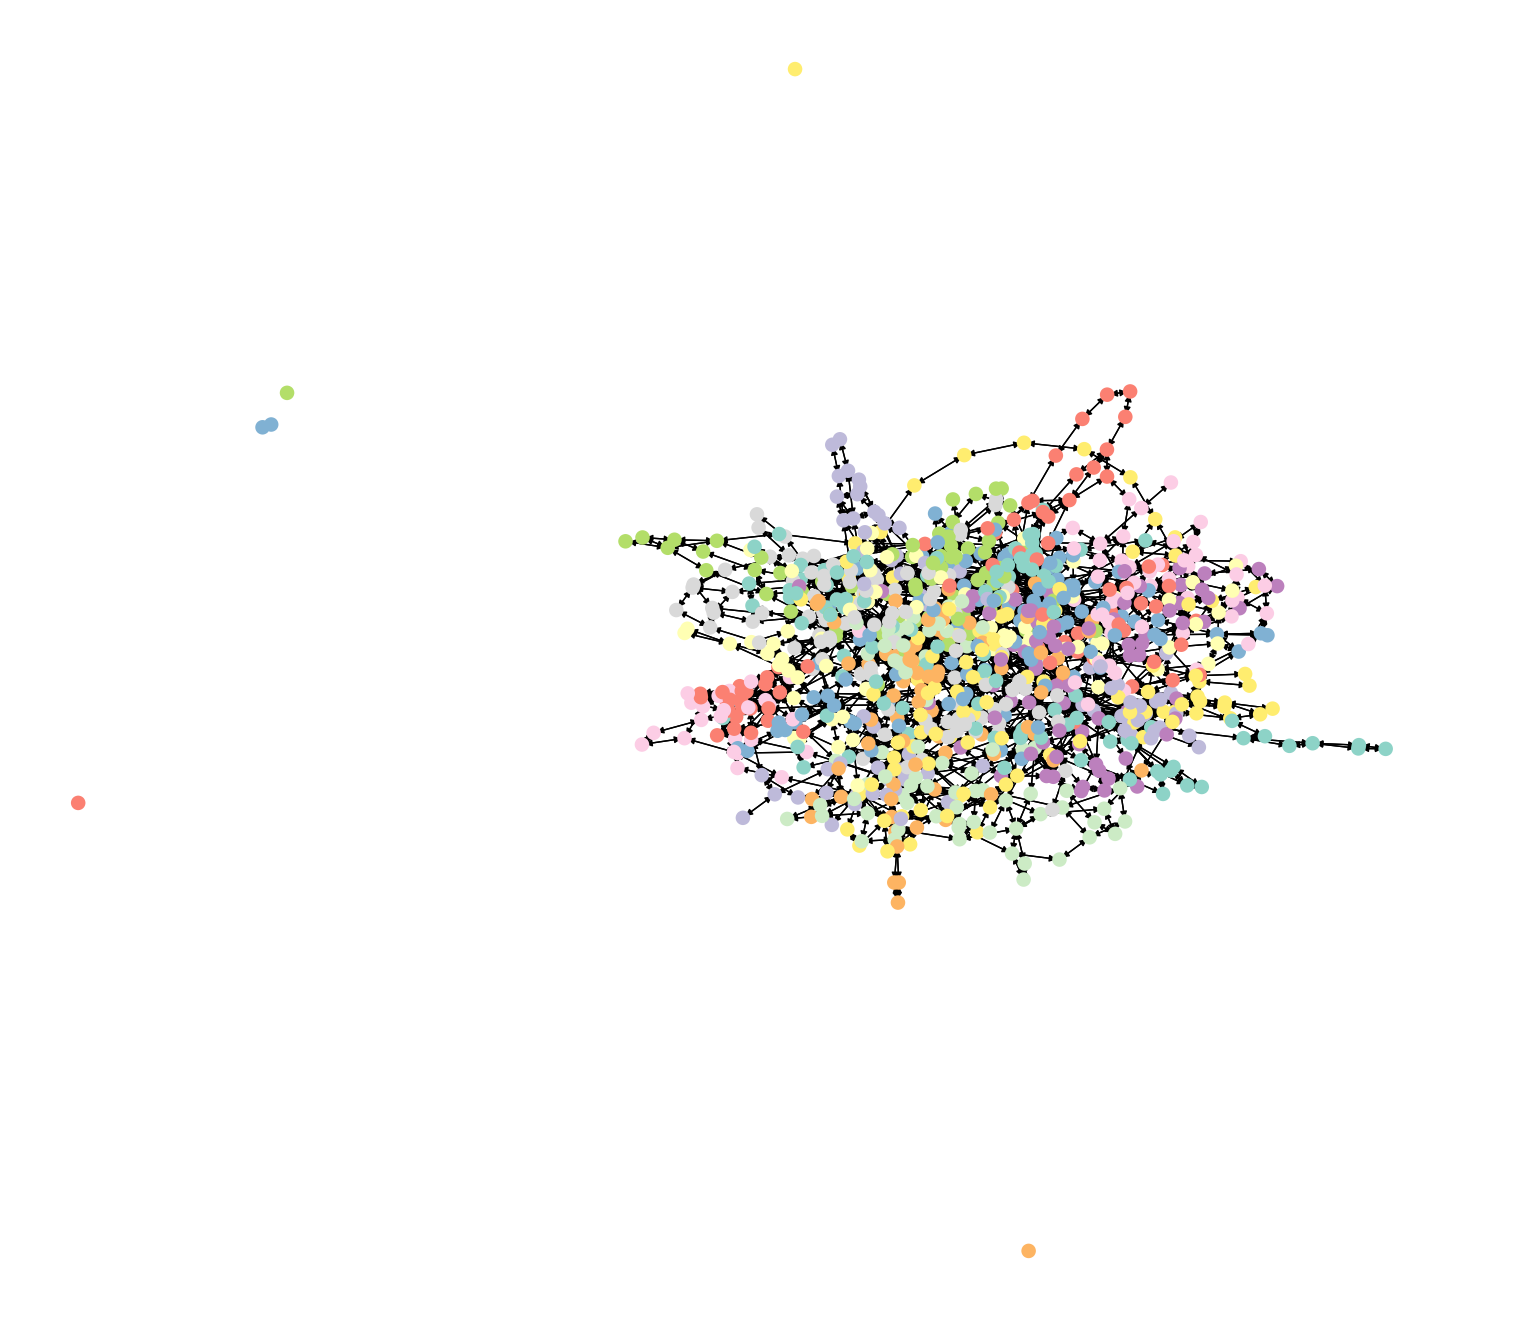

In [7]:
vis = to_networkx(lfr_test)
vis.remove_edges_from(nx.selfloop_edges(vis))


node_labels = lfr_test.y.numpy()

import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=20,linewidths=6)
plt.show()


In [79]:
!pip install community

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for community: filename=community-1.0.0b1-py3-none-any.whl size=2143 sha256=81d1ee1cdae454a59a726585e5314883218c1295da7ed12386430ed70464e564
  Stored in directory: c:\users\jaide\appdata\local\pip\cache\wheels\b7\c9\3f\e222b011e31d3d1de1fd799caed228f770d56f66563014285d
Successfully built community
